Back to the [ML Notebook](./ml.ipynb)

To the [README](./README.md)

--------------------------------------------------------------------------------

# Random Forest

In [7]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import ConfusionMatrixDisplay, root_mean_squared_error

# set the theme for seaborn graphics
sns.set_theme(context='paper', style='whitegrid')

In [8]:
# load the training and testing data
df_train_ = pd.read_csv('data/df_train.csv', index_col=0)
df_test_ = pd.read_csv('data/df_test.csv', index_col=0)

In [9]:
# extract four locations; we want to have one model per location
df_train = [
    df_train_[df_train_.Location=='Location 1'].drop('Location', axis=1),
    df_train_[df_train_.Location=='Location 2'].drop('Location', axis=1),
    df_train_[df_train_.Location=='Location 3'].drop('Location', axis=1),
    df_train_[df_train_.Location=='Location 4'].drop('Location', axis=1),
]
df_test = [
    df_test_[df_test_.Location=='Location 1'].drop('Location', axis=1),
    df_test_[df_test_.Location=='Location 2'].drop('Location', axis=1),
    df_test_[df_test_.Location=='Location 3'].drop('Location', axis=1),
    df_test_[df_test_.Location=='Location 4'].drop('Location', axis=1),
]

In [10]:
# define target and features
X_train = [
    df_train[0].drop('Power', axis=1),
    df_train[1].drop('Power', axis=1),
    df_train[2].drop('Power', axis=1),
    df_train[3].drop('Power', axis=1),
]
y_train = [
    df_train[0].Power,
    df_train[1].Power,
    df_train[2].Power,
    df_train[3].Power,
]

X_test = [
    df_test[0].drop('Power', axis=1),
    df_test[1].drop('Power', axis=1),
    df_test[2].drop('Power', axis=1),
    df_test[3].drop('Power', axis=1),
]
y_true = [
    df_test[0].Power,
    df_test[1].Power,
    df_test[2].Power,
    df_test[3].Power,
]

In [11]:
# instantiate Random Forest regressor
forest = [RandomForestRegressor(n_jobs=-1) for _ in range(4)]

In [12]:
# train the model
def model(collection): return collection[0]
def X(collection): return collection[1]
def y(collection): return collection[2]
_ = list(map(
    lambda z: model(z).fit(X(z), y(z)),
    zip(forest, X_train, y_train)
))

In [13]:
# make predictions
y_test = list(map(
    lambda z: model(z).predict(X(z)),
    zip(forest, X_test)
))

In [14]:
# evaluate results
errors = list(map(
    lambda z: root_mean_squared_error(z[0], z[1]),
    zip(y_true, y_test)
))

# display the errors:
for location, error in zip([n+1 for n in range(4)], errors):
    print(f'Location {location}:\tRMSE = {error:.3f}')

Location 1:	RMSE = 0.130
Location 2:	RMSE = 0.092
Location 3:	RMSE = 0.107
Location 4:	RMSE = 0.095


In [15]:
# create a result dataframe for evaluation and graphical display
df_test[0]['Location'] = 'Location 1'
df_test[0]['predicted'] = y_test[0]
df_test[0].rename(columns={'Power': 'actual'}, inplace=True)

df_test[1]['Location'] = 'Location 2'
df_test[1]['predicted'] = y_test[1]
df_test[1].rename(columns={'Power': 'actual'}, inplace=True)

df_test[2]['Location'] = 'Location 3'
df_test[2]['predicted'] = y_test[2]
df_test[2].rename(columns={'Power': 'actual'}, inplace=True)

df_test[3]['Location'] = 'Location 4'
df_test[3]['predicted'] = y_test[3]
df_test[3].rename(columns={'Power': 'actual'}, inplace=True)

results = pd.concat(df_test, axis=0)

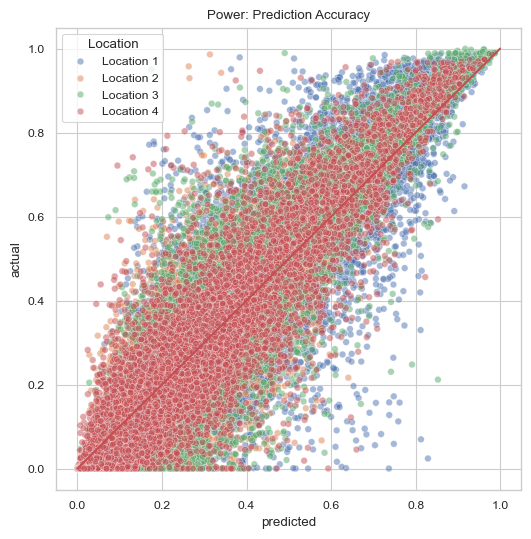

In [26]:
# graphical visualization
plt.figure(figsize=(6,6))
sns.scatterplot(results, x='predicted', y='actual', hue='Location', alpha=.5)
plt.plot([[0,0], [1,1]], color='r')
plt.title('Power: Prediction Accuracy')
plt.show()

Let's see if we can remove some noise from the training data by removing less
relevant features.  For that, we take a look at the feature importances.
For the Random Forest model for location 1, for instance, we find the following
ranking:

In [17]:
pd.DataFrame(zip(X_test[0].columns, forest[0].feature_importances_), columns=['feature', 'importance']).sort_values('importance', ascending=False)

,feature,importance
18,windspeed_100m_n,0.681031
16,dewpoint_2m_n,0.029988
14,temperature_2m_n,0.029361
11,Day of Year_c,0.028738
19,windgusts_10m_n,0.028288
10,Day of Year_s,0.027399
15,relativehumidity_2m_n,0.023975
17,windspeed_10m_n,0.020571
12,Hour_s,0.019576
4,winddirection_100m_s,0.018587


Obviously, `windspeed_100m` is *the* telling feature for the power output prediction.
But relying on that alone is not a good idea, as this little experiment
illustrates:

In [18]:
narrow_minded_forest = RandomForestRegressor().fit(X_train[0].windspeed_100m_n.to_frame(), y_train[0])
narrow_minded_pred = narrow_minded_forest.predict(X_test[0].windspeed_100m_n.to_frame())

In [19]:
root_mean_squared_error(y_true[0], narrow_minded_pred)

0.17073665907306484

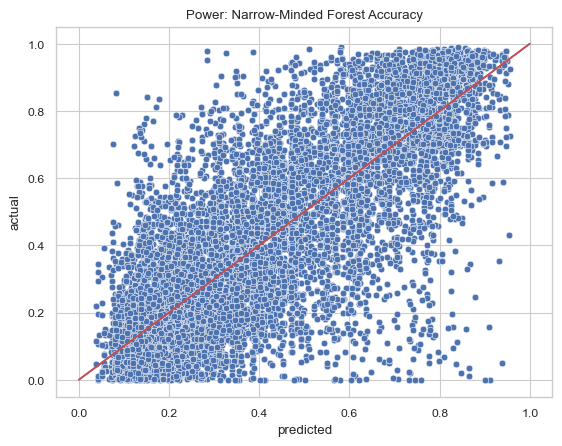

In [20]:
sns.scatterplot(pd.DataFrame({
    'actual': y_true[0],
    'predicted': narrow_minded_pred
}), x='predicted', y='actual')
plt.plot([[0,0], [1,1]], color='r')
plt.title('Power: Narrow-Minded Forest Accuracy')
plt.show()

So what if we include only the features with an importance of, say, $0.015$ or higher?

In [21]:
# extract only "important" features
features = [
    [
        model.feature_names_in_[idx]
        for idx, imp in zip(range(len(model.feature_importances_)), model.feature_importances_)
        if imp >= 0.015
    ]
    for model in forest
]

In [22]:
# repeat the process with a subset of the features

# train the models
_ = list(map(
    lambda z: model(z).fit(X(z)[z[3]], y(z)),
    zip(forest, X_train, y_train, features)
))

# make predictions
y_test_reduced_featureset = list(map(
    lambda z: model(z).predict(X(z)[z[2]]),
    zip(forest, X_test, features)
))

# evaluate results
errors_reduced_featureset = list(map(
    lambda z: root_mean_squared_error(z[0], z[1]),
    zip(y_true, y_test_reduced_featureset)
))

# display the errors:
for location, error in zip([n+1 for n in range(4)], errors_reduced_featureset):
    print(f'Location {location}:\tRMSE = {error:.3f}')

Location 1:	RMSE = 0.134
Location 2:	RMSE = 0.094
Location 3:	RMSE = 0.107
Location 4:	RMSE = 0.100


As it turns out, none of those values represents an improvement compared to
the previous results:

    Location 1:	RMSE = 0.130
    Location 2:	RMSE = 0.092
    Location 3:	RMSE = 0.107
    Location 4:	RMSE = 0.095

Now another option we have is to tweak the parameters of the `RandomForestRegressor`
itself.  As of now, we just used the default instantiation parameters.  However,
those defaults actually represent quite an exhaustive forest, with unlimited
search depth (that is, until the default minimum leaf size of $1$ has been
reached), 100 independant estimators and with `'squared_error'` a loss criterium
similar to our evaluation metric.  We could try out `'friedman_mse'` as an
alternative, but that wouldn't have a huge impact on our scores.

So we are essentially done with Random Forest at this point and can consider
the scores we found as a benchmark for other models.

Next up is an artificial neural network in the [ANN notebook](./ann.ipynb).